# CS492: 전산학특강<스마트에너지를 위한 인공지능> 
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

# Week 4 - Cumstomization and Adavnce models 
## Schedule of this week
7. **Customization of your model** (Day7) <br>
    7-1. Functional API  <br>
    7-2. Cumstomization of loss and metric <br>
    7-3. Several options for optimizer and training <br>
    7-4. Subclassing and GradientTape <br>
    7-5. Custom layers and training <br>
    
1. **Introduction to Advanced models** (Day8) <br>
    8-1. Neural machine translation with attention <br>
    8-2. Image captioning with visual attention <br>
    8-3. Transformer
---

## Day 7 - Customization of your models
### 7-1. Functional API in Tensorflow 
#### (Customization of sequence of forward passing)

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

#### Building a model using functional API 

You're already familiar with the use of `keras.Sequential()` to create models. The _Functional API_ is **a way to create models that is more flexible than _Sequential_: it can handle models with non-linear topology, models with shared layers, and models with multiple inputs or outputs.**

It's based on the idea that a deep learning model is usually a directed acyclic graph (DAG) of layers. The Functional API a set of tools for building graphs of layers.

Consider the following model:
``` python
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: probability distribution over 10 classes)
```

It's a simple graph of 3 layers.

To build this model with the functional API, you would start by creating an _input node_:

In [40]:
from tensorflow import keras
# Build an input node
inputs = keras.Input(shape=(784,))

if the input shape is a (32, 32, 3) image, we can build the input node as follows: 
``` python 
img_inputs = keras.Input(shape=(32, 32, 3))
```


Here we just specify the shape of our data: 784-dimensional vectors. Note that the batch size is always omitted, **we only specify the shape of each sample.**

In [42]:
inputs.shape

TensorShape([None, 784])

In [43]:
inputs.dtype

tf.float32

You create a new node in the graph of layers by calling a layer on this inputs object:

In [44]:
from tensorflow.keras import layers

# define a new dense layer
dense = layers.Dense(64, activation='relu')

# build the dense layer to the graph of layers
# by feeding outputs of input layer to the dense layer as an input 
# ==> Layer call 
x = dense(inputs)

The _"layer call"_ action is like drawing an arrow from "inputs" to this layer we created. We're "passing" the inputs to the dense layer, and out we get x.

Let's add a few more layers to our graph of layers:

In [45]:
# build more layers 
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

At this point, we can create a Model by specifying its inputs and outputs in the graph of layers:

In [46]:
from tensorflow.keras import Model

# create a model 
model = keras.Model(inputs=inputs, outputs=outputs)

To recap, here is our full model definition process:

``` python
inputs = keras.Input(shape=(784,), name='img')
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')
```

Let's check out what the model summary looks like:

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


We can also plot the model as a graph:

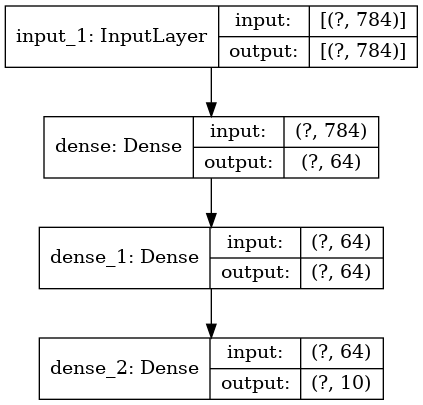

In [13]:
tf.keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

This figure and the code we wrote are virtually identical. In the code version, the connection arrows are simply replaced by the call operation.

A "graph of layers" is a very intuitive mental image for a deep learning model, and the functional API is a way to create models that closely mirrors this mental image.

#### Training, evaluation, and inference

Training, evaluation, and inference work exactly in the same way for models built using the Functional API as for Sequential models.

To simply demonstrate our model, we load MNIST image data, reshape it into vectors, fit the model on the data (while monitoring performance on a validation split), and finally we evaluate our model on the test data:

In [47]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 3s 72us/sample - loss: 0.3499 - accuracy: 0.9005 - val_loss: 0.1837 - val_accuracy: 0.9456
Epoch 2/5
48000/48000 [==============================] - 3s 65us/sample - loss: 0.1568 - accuracy: 0.9533 - val_loss: 0.1438 - val_accuracy: 0.9570
Epoch 3/5
48000/48000 [==============================] - 3s 65us/sample - loss: 0.1168 - accuracy: 0.9649 - val_loss: 0.1280 - val_accuracy: 0.9617
Epoch 4/5
48000/48000 [==============================] - 3s 65us/sample - loss: 0.0916 - accuracy: 0.9721 - val_loss: 0.1296 - val_accuracy: 0.9617
Epoch 5/5
48000/48000 [==============================] - 3s 65us/sample - loss: 0.0750 - accuracy: 0.9769 - val_loss: 0.1139 - val_accuracy: 0.9673
Test loss: 0.11577015392491594
Test accuracy: 0.9644


#### Using the same graph of layers to define multiple models
In the functional API, models are created by specifying their inputs and outputs in a graph of layers. **That means that a single graph of layers can be used to generate multiple models.**

**Simple autoencoder example:** <br>
In the example below, we use the same stack of layers to instantiate two models: an `encoder` model that turns image inputs into 16-dimensional vectors, and an end-to-end `autoencoder` model for training.
<img src=https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png>

[`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose): Transposed convolution layer (sometimes called Deconvolution). <br>
[`tf.keras.layers.UpSampling2D
`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D): Upsampling layer for 2D inputs. (`size`: The upsampling factors for rows and columns.)

In [48]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
# (28x28x1)
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
# (26x26x16)
x = layers.Conv2D(32, 3, activation='relu')(x)
# (24x24x32)
x = layers.MaxPooling2D(3)(x)
# (8x8x32)
x = layers.Conv2D(32, 3, activation='relu')(x)
# (6x6x32)
x = layers.Conv2D(16, 3, activation='relu')(x)
# (4x4x16)
encoder_output = layers.GlobalMaxPooling2D()(x)
# (16,)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_5 (Glob (None, 16)                0   

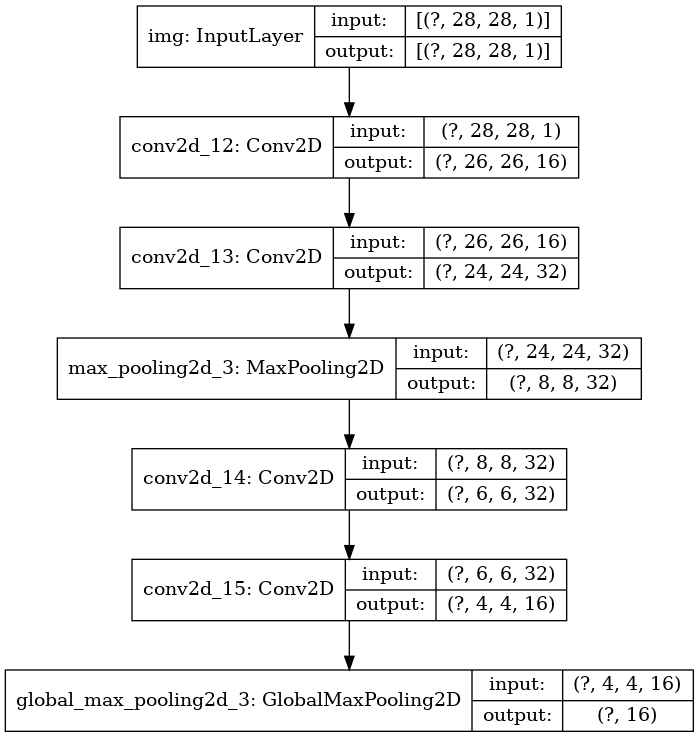

In [32]:
tf.keras.utils.plot_model(encoder, 'encoder.png', show_shapes=True)

In [49]:
# use the output of encoder model as an input of autoencoder model.
x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

# define the model using encoder_input and decoder_output
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_5 (Glob (None, 16)                

In [ ]:
tf.keras.utils.plot_model(autoencoder, 'autoencoder.png', show_shapes=True)

#### All models are callable, just like layers
You can treat any model as if it were a layer, by calling it on an Input or on the output of another layer. Note that by calling a model you aren't just reusing the architecture of the model, **you're also reusing its weights.**

Let's see this in action. Here's a different take on the autoencoder example that creates an encoder model, a decoder model, and chain them in two calls to obtain the autoencoder model:

In [50]:
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img') 
# encoder_input = keras.Input(shape=(784,))
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_6 (Glob (None, 16)                0   

In [51]:
decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_img (InputLayer)     [(None, 16)]              0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 6, 6, 16)          160       
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 26, 26, 16)        4624      
_________________________________________________________________
conv2d_transpose_35 (Conv2DT (None, 28, 28, 1)         145 

In [52]:
autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
# autoencoder_input = keras.Input(shape=(784,))
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                18672     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9569      
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


As you can see, **model can be nested: a model can contain submodels (since a model is just like a layer).**

**A common use case for model nesting is _ensembling_.** As an example, here's how to ensemble a set of models into a single model that averages their predictions:

In [54]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1, activation='sigmoid')(inputs)
    return keras.Model(inputs, outputs)

model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

**Advantages of ensembling method:**
1. Reducing an overfitting by combining several models.
1. Improving the overall performance when each model performance is low

For more detailed explanation about ensembliig method, refer to this site: https://en.wikipedia.org/wiki/Ensemble_learning

#### Manipulating complex graph topologies
The **functional API makes it easy to manipulate multiple inputs and outputs**. This cannot be handled with the Sequential API.

Here's a simple example.

Let's say you're building a system for ranking custom issue tickets by priority and routing them to the right department.

You model will have 3 inputs:
- Title of the ticket (text input)
- Text body of the ticket (text input)
- Any tags added by the user (categorical input)

It will have two outputs:
- Priority score between 0 and 1 (scalar sigmoid output)
- The department that should handle the ticket (softmax output over the set of departments)

Let's built this model in a few lines with the Functional API.

In [55]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(shape=(None,), name='title')  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name='body')  # Variable-length sequence of ints
tags_input = keras.Input(shape=(num_tags,), name='tags')  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)
# input shape of embeeding layer: (batch_size, input_length)
# output shape of embedding layer: (batch_size, input_length, embedding_dim)

# Reduce sequence of embedded words in the title into 
# a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into 
# a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, activation='sigmoid', name='priority')(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, activation='softmax', name='department')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[title_input, body_input, tags_input],
                    outputs=[priority_pred, department_pred])

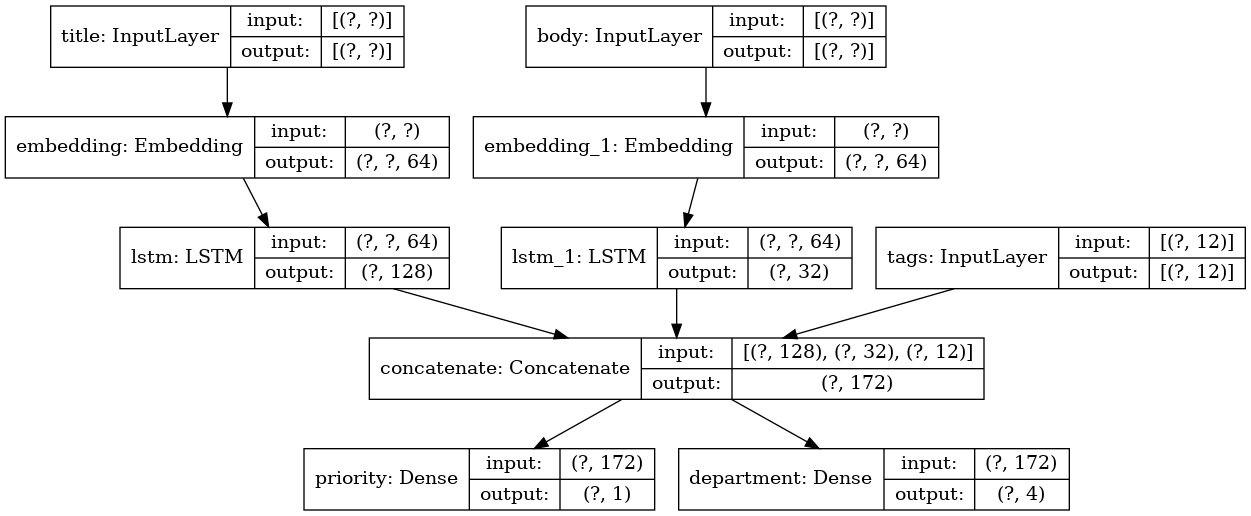

In [56]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

When compiling this model, we can **assign different losses to each output.** You can even **assign different weights to each loss**, to modulate their contribution to the total training loss. (e.g., Be able to adjust weight of important loss to affect learning more)

In [58]:
# specify the loss using the names of output layers

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'priority': 'binary_crossentropy',
                    'department': 'categorical_crossentropy'},
              loss_weights=[1., 0.2])

"""
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=['binary_crossentropy', 'categorical_crossentropy'],
              loss_weights=[1., 0.2])
"""

"\nmodel.compile(optimizer=keras.optimizers.RMSprop(1e-3),\n              loss=['binary_crossentropy', 'categorical_crossentropy'],\n              loss_weights=[1., 0.2])\n"

We can train the model by passing lists of Numpy arrays of inputs and targets:

In [65]:
import numpy as np

# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')

print(title_data.shape)
print(body_data.shape)
print(tags_data.shape)
print("-------------------\n")

print(title_data[0])
print(body_data[0])
print(tags_data[0])

(1280, 10)
(1280, 100)
(1280, 12)
-------------------

[ 164 2955 3495 6020  474  694 8980 4802 6906 6907]
[9365 9612 6232 4761 4577 3437 2759 7453 8392 3011 3655  596 6646 6979
 1477 5502 4744 1769 3373 5558 5634 9213 6110 2478 5672 1527 7787 2406
 6494  260 3049 8200 5693  224 7935 6076 2502  352 7229  453 7966 3417
 1789 3296 5168 8533 9532 4816 4957 8529 2749  324 1372 5467 5527 2311
 8752 7919 2041 8857 9815 1103 9394 1162 3441 4324 1099 1870  256 8931
 8819 4682 5981 4742 8473 6820 4136 9268 3424 6604 9702 9877 2042 7813
 7477  744 4089 8963 9439 1789 8454 7659 5915 3972 3130 3149 1313 4331
 8168  327]
[0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1.]


In [67]:
# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

print(priority_targets[0])
print(dept_targets[0])

[0.54823427]
[1 1 0 0]


In [68]:
model.fit({'title': title_data, 'body': body_data, 'tags': tags_data}, # set training data
          {'priority': priority_targets, 'department': dept_targets},  # set target data (labels)
          epochs=2,
          batch_size=32)

Train on 1280 samples
Epoch 1/2


W0928 06:56:01.158505 139635603236672 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1280/1280 [==============================] - 5s 4ms/sample - loss: 1.2652 - priority_loss: 0.7016 - department_loss: 2.8182
Epoch 2/2
1280/1280 [==============================] - 1s 647us/sample - loss: 1.2654 - priority_loss: 0.7024 - department_loss: 2.8153


When calling fit with a `Dataset` object, it should yield either a tuple of lists like `([title_data, body_data, tags_data], [priority_targets, dept_targets])` or a tuple of dictionaries like `({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets})`.

#### A toy resnet model
In addition to models with multiple inputs and outputs, **the Functional API makes it easy to manipulate non-linear connectivity topologies**, that is to say, models where layers are not connected sequentially. This also cannot be handled with the Sequential API (as the name indicates).

A common use case for this is **residual connections**.
<img src=https://miro.medium.com/proxy/1*rbhjv7ZdAgXM2MlBUL5Mmw.png>

Let's build a toy ResNet model for CIFAR10 to demonstrate this.

In [69]:
inputs = keras.Input(shape=(32, 32, 3), name='img')
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
# use the block_1_output and x as an input
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
# use the block_2_output and x as an input
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation='relu')(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='toy_resnet')
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_29[0][0]                  
_________________________________________________________________________________________

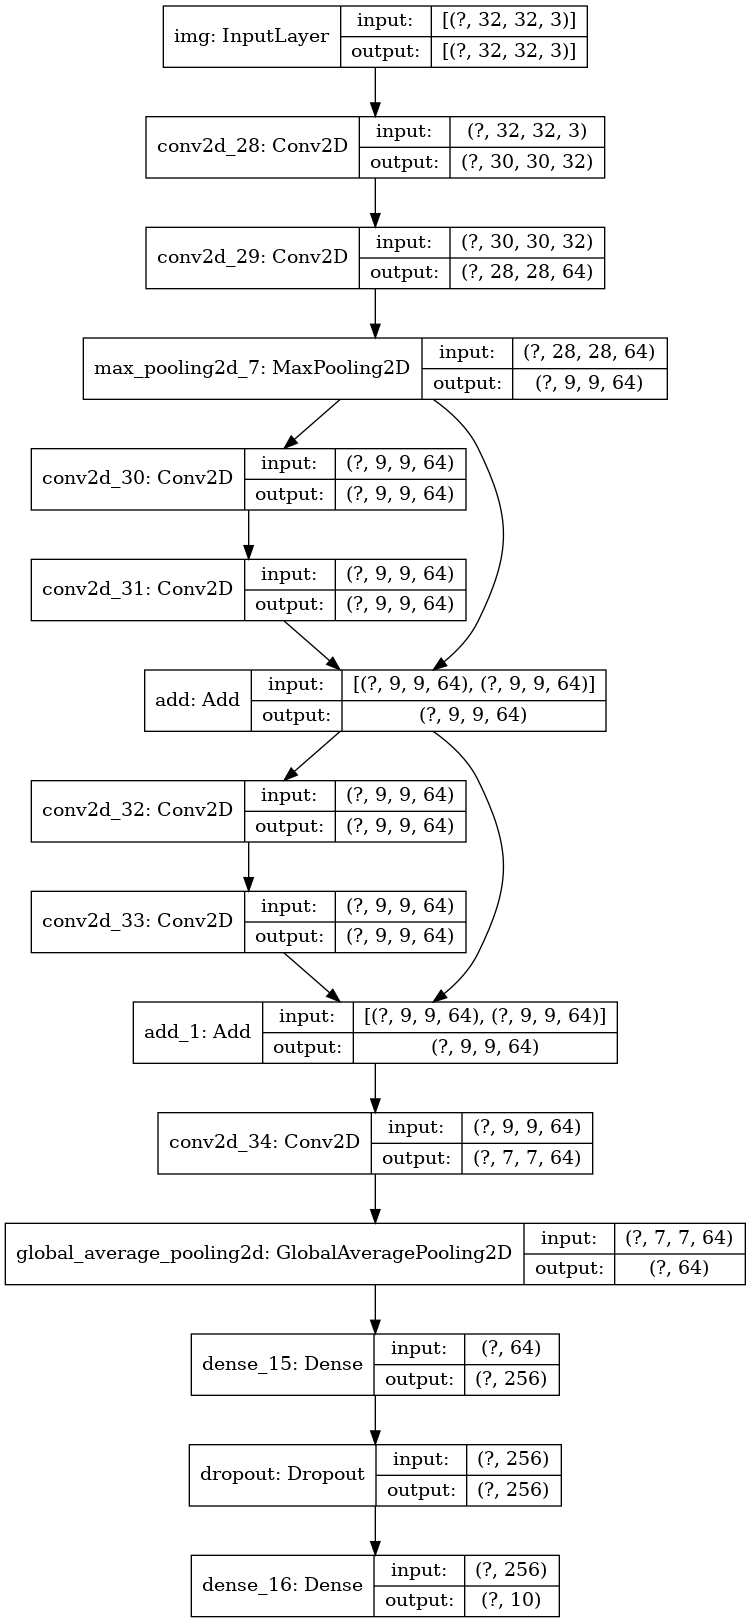

In [70]:
keras.utils.plot_model(model, 'mini_resnet.png', show_shapes=True)

In [71]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss='categorical_crossentropy',
              metrics=['acc'])

model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          validation_split=0.2)

170500096/170498071 [==============================] - 138s 1us/step
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 9s 214us/sample - loss: 1.9087 - acc: 0.2772 - val_loss: 1.4930 - val_acc: 0.4469
